In [1]:
import tensorflow as tf
import numpy as np

In [13]:
# Define the diffusion coefficient
D = 0.1  # Example diffusion coefficient

# Define the neural network
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(50, activation='tanh') for _ in range(3)
        ]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

def compute_residual(pinn, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        C = pinn(tf.concat([x, t], axis=1))
        dC_dt = tape.gradient(C, t)
        dC_dx = tape.gradient(C, x)

    d2C_dx2 = tape.gradient(dC_dx, x)  # Second derivative w.r.t x
    del tape  # Manually delete the tape to free resources

    residual = dC_dt - D * d2C_dx2
    return residual



# Data Preparation
def generate_collocation_points(n_points=10000):
    x = np.random.uniform(0, 1, (n_points, 1))
    t = np.random.uniform(0, 1, (n_points, 1))
    return tf.convert_to_tensor(x, dtype=tf.float32), tf.convert_to_tensor(t, dtype=tf.float32)

def generate_initial_condition_points(n_points=100):
    x = np.random.uniform(0, 1, (n_points, 1))
    t = np.zeros((n_points, 1))  # Initial time (t=0)
    C = np.sin(np.pi * x)  # Example IC: sinusoidal profile
    return (tf.convert_to_tensor(x, dtype=tf.float32),
            tf.convert_to_tensor(t, dtype=tf.float32),
            tf.convert_to_tensor(C, dtype=tf.float32))

def generate_boundary_condition_points(n_points=100):
    t = np.random.uniform(0, 1, (n_points, 1))
    x_min = np.zeros((n_points, 1))
    x_max = np.ones((n_points, 1))
    C_left = np.zeros((n_points, 1))  # Dirichlet BC
    C_right = np.zeros((n_points, 1))  # Dirichlet BC
    return (tf.convert_to_tensor(x_min, dtype=tf.float32), tf.convert_to_tensor(C_left, dtype=tf.float32),
            tf.convert_to_tensor(x_max, dtype=tf.float32), tf.convert_to_tensor(C_right, dtype=tf.float32),
            tf.convert_to_tensor(t, dtype=tf.float32))

# Training the PINN
@tf.function
def train_step(pinn, optimizer, x_col, t_col, x_ic, t_ic, C_ic, x_min, C_left, x_max, C_right, t_bc):
    with tf.GradientTape() as tape:
        # Residual loss
        residual = compute_residual(pinn, x_col, t_col)
        loss_pde = tf.reduce_mean(tf.square(residual))

        # Initial condition loss
        C_pred = pinn(tf.concat([x_ic, t_ic], axis=1))
        loss_ic = tf.reduce_mean(tf.square(C_pred - C_ic))

        # Boundary condition loss
        C_left_pred = pinn(tf.concat([x_min, t_bc], axis=1))
        C_right_pred = pinn(tf.concat([x_max, t_bc], axis=1))
        loss_bc = tf.reduce_mean(tf.square(C_left_pred - C_left)) + tf.reduce_mean(tf.square(C_right_pred - C_right))

        # Total loss
        loss = loss_pde + loss_ic + loss_bc

    gradients = tape.gradient(loss, pinn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))
    return loss

# Instantiate the PINN
pinn = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Generate training data
x_col, t_col = generate_collocation_points()
x_ic, t_ic, C_ic = generate_initial_condition_points()
x_min, C_left, x_max, C_right, t_bc = generate_boundary_condition_points()

# Training loop
n_epochs = 500
for epoch in range(n_epochs):
    loss = train_step(pinn, optimizer, x_col, t_col, x_ic, t_ic, C_ic, x_min, C_left, x_max, C_right, t_bc)
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Use the trained PINN for predictions
x_test = tf.convert_to_tensor(np.linspace(0, 1, 100).reshape(-1, 1), dtype=tf.float32)
t_test = tf.convert_to_tensor(np.linspace(0, 1, 100).reshape(-1, 1), dtype=tf.float32)
C_pred = pinn(tf.concat([x_test, t_test], axis=1))



Epoch 0, Loss: 0.8139649033546448


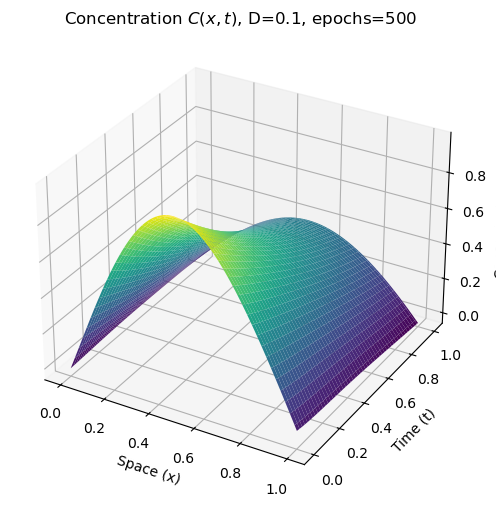

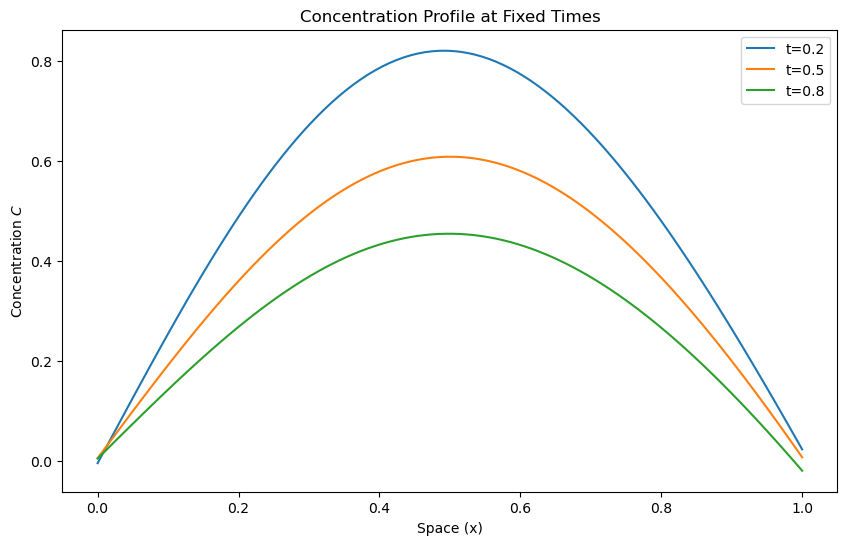

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate test points (grid over space and time)
x_test = np.linspace(0, 1, 100)
t_test = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_test, t_test)

# Flatten the grid to feed into the neural network
x_flat = X.flatten().reshape(-1, 1)
t_flat = T.flatten().reshape(-1, 1)

# Use the trained PINN to predict concentrations
C_pred_flat = pinn(tf.convert_to_tensor(np.hstack((x_flat, t_flat)), dtype=tf.float32))
C_pred = C_pred_flat.numpy().reshape(X.shape)

# 1. 3D Surface Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, C_pred, cmap='viridis', edgecolor='none')
ax.set_title(f'Concentration $C(x, t)$, D={D}, epochs={n_epochs}')
ax.set_xlabel('Space (x)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Concentration $C$')
plt.show()

# 2. 1D Slices: Concentration vs Space at Different Times
plt.figure(figsize=(10, 6))
for t_fixed in [0.2, 0.5, 0.8]:  # Example time points
    t_slice = np.full_like(x_test, t_fixed).reshape(-1, 1)
    C_slice = pinn(tf.convert_to_tensor(np.hstack((x_test.reshape(-1, 1), t_slice)), dtype=tf.float32))
    plt.plot(x_test, C_slice.numpy(), label=f't={t_fixed}')

plt.title('Concentration Profile at Fixed Times')
plt.xlabel('Space (x)')
plt.ylabel('Concentration $C$')
plt.legend()
plt.show()
